In [1]:
import synapseclient
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import scipy.stats as stats
from collections import Counter as c
import sparklines

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
mpl.rcParams['figure.figsize'] = (15.0, 8.0)
mpl.rc('font', **{'family' : 'Arial','size'   : 14})


syn = synapseclient.login()

## callibration study data
hr_data_entity_id = 'syn17973172'
metadata_entity_id = 'syn17009128'
skin_tone_id = 'syn18082209'
phone_metrics_id ='syn18456060'

## Validation study data
EPARC_DATA = 'syn12257142'
MERGED_HR_FILE_IDS = {'tecumesh':'syn12612345', 'stress_test':'syn12612346', '12MT':'syn12612344', }
ACTIVITY_TABLE_IDS = {'12MT':'syn11665074', 'tecumesh':'syn11432994', 'stress_test':'syn11580624'}
VO2MAX_TECUMESH_FILE_ID = 'syn14746485'
COMPUTED_DISTANCES_ID = 'syn15382305'
FITZPATRICK_FILE_ID = 'syn15343217'
QUERY = "SELECT * FROM %s where externalId like 'PMI%%'"


Welcome, Larsson Omberg!



## Plottting functions and helper functions

In [2]:
def plot_bland_altman(x,y, c=None, xlabel='average in values', ylabel='difference in values'):
    """given measurements for x and y plots difference vs average with standard deviation lines. """
    diff_vals = x-y
    avg_vals = (x+y)/2.
    plt.scatter(avg_vals, diff_vals, c=c)
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean(),diff_vals.mean()], 'k')
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean()+diff_vals.std(),diff_vals.mean()+diff_vals.std()], 'r')
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean()-diff_vals.std(),diff_vals.mean()-diff_vals.std()], 'r')
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
def ccc(x,y):
    """Computes the correlation between  two values.
    Returns the correlation coefficient"""
    if len(x)==0:
        return np.NaN
    covar = np.cov(x,y, bias=False)[0][1]*(len(x)-1)/float(len(x)) 
    xvar = np.var(x, ddof=1)*(len(x)-1)/float(len(x)) 
    yvar = np.var(y, ddof=1)*(len(y)-1)/float(len(y))
    return (2 * covar) / ((xvar+yvar) +((np.mean(x)-np.mean(y))**2))
    #corr = stats.pearsonr(x, y)
    #return corr[0]

def shakey(r):
    if r.Sex=='Male':
        val= 3.744*(r['Lab Day Wt (kg)']+5)/(64.83-62+.662*r.hb15to30)
    else:
        val = 3.75*(r['Lab Day Wt (kg)']-3)/(51.33-65+0.75*r.hb15to30)
    return val*r.weight/1000 if val>0 else np.nan

def milligan1(HB30to60s, age):
    return (84.687 - 0.722*HB30to60s - 0.383*age)

def milligan2(HB30to60s, age, sex):
    return  83.477 - 0.586*HB30to60s - 0.404*age - 7.030*(sex=='Female')

# Load and transform Data
## Load Calibration Metadata
Load data from multiple data sources and print demographics and summary plots for skin and devices

In [3]:
# Get data from Synapse
calibration_metadata_entity = syn.tableQuery('select * from %s where "Participant ID">1' % metadata_entity_id)
calibration_data_entity = syn.get(hr_data_entity_id)
calibration_skintone_entity = syn.get(skin_tone_id)
calibration_phone_metrics = syn.get(phone_metrics_id)

# Read into data frames
calibration_metadata = calibration_metadata_entity.asDataFrame()
calibration_metadata = calibration_metadata.rename(columns = {'Participant ID': 'participantID', 'Celeb Choice - Please select the number that best matches you based on your skin.': 'celeb skintone'})
calibration_metadata = calibration_metadata.dropna(subset=['participantID'])
calibration_metadata = calibration_metadata.loc[:, ~calibration_metadata.columns.str.contains('Nonin File')]
df = pd.read_csv(calibration_data_entity.path, sep=',', index_col=0, low_memory=False)
df['redHR'] = df.redHR.astype('float')
df['greenHR'] = df.greenHR.astype('float')
df['blueHR'] = df.blueHR.astype('float')
df['window'] = df.window.str.replace('Window', '').astype('float')
df['startTime'] = pd.to_datetime(df.startTime)
df['stopTime'] = pd.to_datetime(df.stopTime)
df['%error'] = (df['redHR'] - df['noninHR'])/df['noninHR']*100
calibration_phone_metrics = pd.read_csv(calibration_phone_metrics.path, sep=',', index_col=0, low_memory=False)


calibration_skin = pd.read_csv(calibration_skintone_entity.path, sep=',', index_col=0)
calibration_skin = calibration_skin.rename(columns = {'Participant ID': 'participantID', 'Celeb Choice - Please select the number that best matches you based on your skin.': 'celeb skintone'})
## Drop problematic data collections by dropping duplicates
#   participant 1220 was redone and this was the first
calibration_metadata = calibration_metadata[~((calibration_metadata['participantID']==1220) & 
                                              (calibration_metadata['Face L*']==69) & 
                                              (calibration_metadata['Face b*']==17.8))]
calibration_skin = calibration_skin[~((calibration_skin['participantID']==1220) & 
                                      (calibration_skin['Face L*']==69) & 
                                      (calibration_skin['Face b*']==17.8))]
#  drop the first measurement of 5640 as it was repeated and made more complete
calibration_metadata = calibration_metadata[~((calibration_metadata['participantID']==5640) & 
                                              (calibration_metadata['Face L*']==61.2) & 
                                              (calibration_metadata['Face b*']==22.4))]
calibration_skin = calibration_skin[~((calibration_skin['participantID']==5640) & 
                                      (calibration_skin['Face L*']==61.2) & 
                                      (calibration_skin['Face b*']==22.4))]

print('Last update performed %s' %calibration_data_entity.modifiedOn)
print('%i participants in survey' %len(set(calibration_metadata['participantID'])))
print('%i particpiants with phone data' % len(set(df.participantID)))
df = calibration_metadata.merge(df, on='participantID', how='right')
calibration_df = df.merge(calibration_skin[['participantID', 'face.fitzpatrick.ita', 'finger.fitzpatrick.ita', 
                    'face.fitzpatrick', 'finger.fitzpatrick']], 
                  on='participantID', how='left')
print('%i particpiants with matched data\n' % len(set(calibration_df.loc[~df['noninHR'].isna() & (df.method=='acf'), 
                                                      'participantID'])))
calibration_df[~calibration_df['noninHR'].isna() & (calibration_df.method=='acf')].groupby(['face.fitzpatrick', 'phone'])['participantID'].nunique().astype('int16').unstack('face.fitzpatrick')
#calibration_df[~calibration_df['noninHR'].isna() & (calibration_df.method=='acf')].groupby(['celeb skintone', 'phone'])['participantID'].nunique().astype('int16').unstack('celeb skintone')


Last update performed 2019-11-12T05:59:17.048Z
127 participants in survey
124 particpiants with phone data
120 particpiants with matched data



face.fitzpatrick,1,2,3,4,5
phone,,,,,
Huawei Mate SE,3,23,45,29,16
LG Stylo 4,2,25,39,28,13
Moto G6 Play,3,19,26,18,9
Samsung Galaxy J7,1,13,24,14,7
Samsung Galaxy S9+,2,18,32,17,10
iPhone 8+,3,24,44,29,15
iPhone SE,3,24,44,30,17
iPhone XS,3,23,41,27,17


## Load Validation and VO2Max Data

In [4]:
metadata = syn.get(EPARC_DATA)
#print(metadata.path)
metadata = (pd.read_excel(metadata.path)
      .assign(BMI = lambda df: df['Lab Day Wt (kg)']/(df['Height (cm)']/100)**2)
      .rename(columns={'Measured HR Max':'Max HR',
                      'Measured VO2max (mL/kg/min)': 'VO2max (mL/kg/min)',
                      "CRF User name": "externalId"}))

#### Load the Validation Fitzpatrick skin tone values

In [5]:
ent = syn.get(FITZPATRICK_FILE_ID)
fitzpatrick = pd.read_excel(ent.path)

#### Load all Validation HR data 
Merge HR data from different tasks into a common dataset for HR

In [6]:
numeric_cols=['samplingRate', 'redHR', 'redConf', 'greenHR', 'greenConf', 'blueHR']
dfs=[]
for name, synId in MERGED_HR_FILE_IDS.items():
    entity  = syn.get(synId)
    df  = pd.read_csv(entity.path, index_col=0, sep=',\s+', delimiter=',', skipinitialspace=True,
                      dtype={col:  'str' for col in numeric_cols})

    for row in numeric_cols:
        df[row] = df[row].str.strip().astype(float)
    df.replace([pd.np.inf, -pd.np.inf], pd.np.nan, inplace=True)
    df['activity'] = name
    df= df[df.appVersion != 'version 1.0.2, build 1']
    dfs.append(df)
df = pd.concat(dfs)
df['os'] = ['iPhone' if 'iPhone' in str else 'Android' for str in df.phoneInfo]
df_hr = df.copy()


####  Load Validation Tecumseh VO2Max estimates

In [7]:
tecumesh = syn.get(VO2MAX_TECUMESH_FILE_ID)
# print(tecumesh.path)
tecumesh = pd.read_csv(tecumesh.path)
tecumesh = tecumesh.merge(df_hr[['recordId', 'os', 'appVersion']].drop_duplicates(), on='recordId', how='left')
tecumesh= tecumesh[tecumesh.appVersion != 'version 1.0.2, build 1']


#### Load Validation Cooper test results and distance calculations

In [8]:
activityTables = {name: syn.tableQuery(QUERY  %synId).asDataFrame() for name, synId in ACTIVITY_TABLE_IDS.items()}

cooperDistances = syn.get(COMPUTED_DISTANCES_ID)
# print(cooperDistances.path)
cooperDistances = pd.read_csv(cooperDistances.path, sep='\t')
cooperDistances['os'] = ['iPhone' if 'iPhone' in str else 'Android' for str in cooperDistances.phoneInfo]

df_12mt = activityTables['12MT']

df_12mt = df_12mt.merge(cooperDistances[['recordId', 'estimated_smoothed_distance', 'estimated_distance', 'actual_distance']], how='left', on='recordId', )
df_12mt['mobile Cooper'] = (df_12mt['estimated_smoothed_distance'] - 504.9)/44.73
df_12mt['inClinic'] = ~df_12mt.actual_distance.isna()

# Table 1

In [9]:
def percent_white(x):
    return sum(x=='White')/len(x)*100
percent_white.__name__ = '% White'

def sparkline_str(x):
    bins=np.histogram(x, [120,130,140,150,160,170,180,190,200,210])[0]
    avg = np.mean(x)
    sl = ''.join(sparklines.sparklines(bins))+'({0:,.0f})'.format(avg)
    return sl
sparkline_str.__name__ = ""

def sparkline_str_vo2max(x):
    bins=np.histogram(x, [15,20,25,30,35,40,45,50,55,60,65])[0]
    avg = np.mean(x)
    sl = ''.join(sparklines.sparklines(bins))+'({0:,.0f})'.format(avg)
    return sl
sparkline_str.__name__ = ""

def mean_std(x):
    return '{0:,.1f} +/- {1:,.1f}'.format(np.mean(x), np.std(x))
mean_std.__name__ = 'mean +/- std)'

def N_female(x):
    return '{}  ({}|{})'.format(len(x), sum(x=='Female'), sum(x=='Male'))
N_female.__name__ = 'N (F|M)'

format_dict = {'mean':'${0:,0.1f}'}

(metadata.groupby([pd.cut(metadata.Age, pd.np.arange(20, 81, 10))])
     .agg({'Sex': N_female, 
       'Age':mean_std,
       'Ethnicity': percent_white,
       'BMI': mean_std,
       #'Lab Resting HR': 'mean',
       'Max HR':sparkline_str,
       'VO2max (mL/kg/min)': sparkline_str_vo2max})
    .style.format(format_dict))
#.background_gradient(subset=pd.IndexSlice['mean',:], cmap='BuGn'))

,Sex,Age,Ethnicity,BMI,Max HR,VO2max (mL/kg/min)
Age,,,,,,
"(20, 30]",16 (7|9),24.6 +/- 3.2,43.75,24.0 +/- 2.9,▁▁▁▁▁▂▃█▂(193),▁▁▁▃▄▆█▆▄▃(47)
"(30, 40]",20 (14|6),35.5 +/- 3.1,65,24.0 +/- 3.5,▁▁▁▁▃▃█▄▃(186),▁▂▂▁▇▅▇█▄▁(44)
"(40, 50]",20 (13|7),44.7 +/- 3.0,65,26.8 +/- 5.4,▁▁▁▁▄▅█▄▁(181),▂▁▂▆▆█▃▂▂▁(39)
"(50, 60]",19 (8|11),55.3 +/- 2.9,68.4211,27.0 +/- 3.9,▁▁▂▁██▆▃▁(174),▁▁▄▆▂█▃▂▃▁(40)
"(60, 70]",14 (11|3),64.8 +/- 3.2,85.7143,28.5 +/- 4.7,▁▃▂▃█▃▂▁▁(160),▂▃▄█▂▁▂▁▁▁(31)
"(70, 80]",5 (3|2),75.0 +/- 3.4,100,27.1 +/- 3.0,▄▄█▁▄▁▁▁▁(141),▁▁█▃▁▃▁▁▁▁(31)


# Figure 1

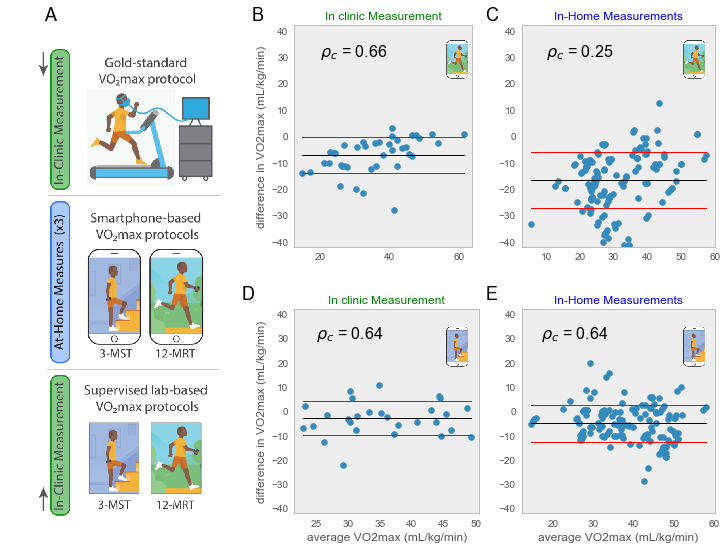

In [10]:
df = df_12mt.copy()
df = df[df['answers.surveyAfter']=='Nothing, was my best effort']
#Merge in true VO2
df = df.merge(metadata[['externalId', 'Age', 'Sex','Cooper VO2', 'VO2max (mL/kg/min)']], how='left', on='externalId')

plt.figure(figsize=(10,10));

#Cooper in lab from smartphone vs VO2Max
ax = plt.subplot(232)
ax.set_position([0.395419, 0.645333, 0.247004, 0.308000])
tmp = df[df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                 ylabel='difference in VO2max (mL/kg/min)', xlabel='');
plt.text(20,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
        fontsize=16,fontname='Arial');
plt.title('In clinic Measurement', fontsize=12, fontname='Arial', color= 'Green')
plt.ylim(-42,42);
plt.grid(False);

#Cooper at home from smartphone vs VO2Max
ax=plt.subplot(233);
ax.set_position([0.711225, 0.645333, 0.267941, 0.308000])
tmp = df[~df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='');
plt.text(10,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
        fontsize=16,  fontname='Arial');
plt.title('In-Home Measurements', fontsize=12, fontname='Arial', color= 'Blue')
plt.ylim(-42,42);
plt.grid(False);

# 3 Minute Step test data
df = tecumesh.copy()
df = df.merge(metadata[['externalId', 'Lab Day Wt (kg)', 'Age', 'Sex','Cooper VO2', 
                        'VO2max (mL/kg/min)', 
                        'Step Test HR Beats']], how='left', on='externalId')
df = df[df.metric=='red']
tmp =df[['externalId', 'inClinic','vo2Max.Milligan2', 'VO2max (mL/kg/min)', 'os']].dropna().groupby(['externalId', 'inClinic']).mean()

#3MST in lab from smartphone vs VO2Max
ax = plt.subplot(235)
ax.set_position([0.395419, 0.275654, 0.257004, 0.283105])
tmp = df[df.inClinic].dropna(subset=['vo2Max.Milligan2','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['vo2Max.Milligan2'], tmp['VO2max (mL/kg/min)'],  
                  ylabel='difference in VO2max (mL/kg/min)', xlabel='average VO2max (mL/kg/min)');
plt.text(25,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']),
        fontsize=16, fontname='Arial');
plt.title('In clinic Measurement', fontsize=12, fontname='Arial', color= 'Green')
plt.ylim(-42,42);
plt.grid(False);

#3MST in lab from smartphone vs VO2Max
ax = plt.subplot(236)
ax.set_position([0.711225, 0.275654, 0.267941, 0.283105])
tmp = df[~df.inClinic].dropna(subset=['vo2Max.Milligan2','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['vo2Max.Milligan2'], tmp['VO2max (mL/kg/min)'],  
                  ylabel='', xlabel='average VO2max (mL/kg/min)');
plt.text(17,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']),
        fontsize=16, fontname='Arial');
plt.title('In-Home Measurements', fontsize=12, fontname='Arial', color= 'Blue')
plt.ylim(-42,42);
plt.grid(False);


#Plot protocol image
ax =  plt.figure(1).add_axes([0.035852, 0.255654, 0.257057, 0.701609]) 
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/protocol.png"))
plt.axis('off');

#Set parameters on Figure and annotate
for ax in plt.figure(1).axes:
    ax.get_xaxis().get_label().set_fontname("Arial")
    ax.get_xaxis().get_label().set_fontsize(12.000000)

plt.figure(1).text(0.047358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.335494, 0.959621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.660518, 0.959621, 'C', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.321535, 0.572782, 'D', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.660518, 0.572782, 'E', transform=plt.figure(1).transFigure,fontsize=18, fontname="Arial");

#Add icons 
plt.axes([0.60540, 0.476171, 0.031425, 0.059172])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_3mst.png"))
plt.axis('off');
plt.axes([0.93540, 0.476171, 0.031425, 0.059172])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_3mst.png"))
plt.axis('off');
plt.axes([0.605840, 0.876851, 0.031425, 0.057068])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_cooper.png"))
plt.axis('off');
plt.axes([0.93540, 0.876851, 0.031425, 0.057068])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_cooper.png"))
plt.axis('off');

plt.savefig('manuscript/figure1.pdf');

**Figure 1** Visual abstract and primary results of validation. (A) Visual abstract, participants in the study were randomized into two groups.  The first group performed a gold standard VO2Max protocol and recieved traning on day 1 while the second group performed the two smartphone protocols on day 1, both groups then performed the two protocols at home three times during a two week period before coming back into the clinic to perform the app measures in lab (group 1) or gold standard VO2Max (group 2). B-E show Bland-Altman plots comparing the Gold standard VO2Max with smartphone measures from : B) Cooper run test performed in lab, C) Cooper test at home (up to 3 repeats per participant), D) 3MST in lab, and E) 3MST at home.  For upper limits of performance comparing non-smartphone measures to gold standard see supplemental figures xxx-yy

#### (supplemental)Figure 1 Ground truth vs lab based tests 
* Cooper vs V02Max from distance measured using track. 
* Tecumseh vs VO2max from chest strap recovery in lab.

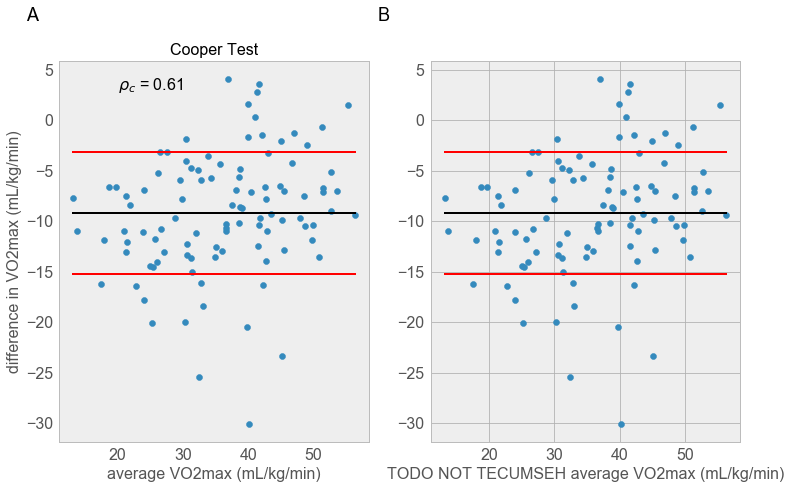

In [11]:
plt.figure(figsize=(12.2,7));

# Cooper in lab validation
plt.subplot(1,2,1);
plot_bland_altman(metadata['Cooper VO2'], metadata['VO2max (mL/kg/min)'], 
                  ylabel='difference in VO2max (mL/kg/min)', xlabel='average VO2max (mL/kg/min)');
plt.text(20,3, '$\\rho_c$ = %0.2f'%ccc(metadata['VO2max (mL/kg/min)'], metadata['Cooper VO2']),
        fontsize=16, fontname='Arial');
plt.title('Cooper Test', fontsize=16, fontname='Arial');
plt.grid(False);

# Tecumseh in lab validation
plt.subplot(1,2,2);
#Compute Tecumseh
# TODO
plot_bland_altman(metadata['Cooper VO2'], metadata['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='TODO NOT TECUMSEH average VO2max (mL/kg/min)');

#Clean up and style plots
for ax in plt.figure(1).axes:
    ax.get_xaxis().get_label().set_fontsize(16.000000);
    ax.get_yaxis().get_label().set_fontsize(16.000000);
    ax.get_xaxis().get_label().set_fontname("Arial");
    ax.get_yaxis().get_label().set_fontname("Arial");
    ax.lines[0].set_linewidth(2.0);
    ax.lines[1].set_linewidth(2.0);
    ax.lines[2].set_linewidth(2.0);
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16);

plt.figure(1).text(0.087358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.487358, 0.959621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");


plt.savefig('manuscript/supplemental_figure1.pdf');

#### Figure 1 c and d:
c) Mobile (In Lab) Cooper vs VO2Max
d) Mobile (In Lab) Cooper vs VO2Max

# Figure 2

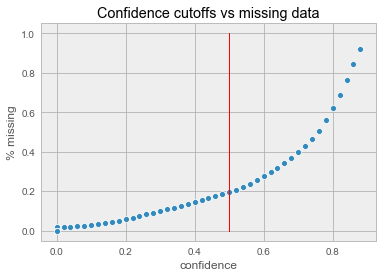

In [12]:
data = (calibration_df.
        query('method=="acf"').
        dropna(subset=['noninHR']))
nSteps=50
nWindows = len(data)
nWindows
confidenceDistributions = pd.DataFrame(np.zeros((nSteps, 3)), columns=['confidence', '% missing', 'concordance'])
        
for i, conf in enumerate(pd.np.arange(0,.9,1/nSteps)):
    data = data.assign(hr = lambda x: np.where(x['redConf']>conf, x['redHR'], 
                               np.where(x['greenConf']>conf, x['greenHR'], np.nan)),
                       conf = lambda x: np.where(x['redConf']>conf, x['redConf'], 
                               np.where(x['greenConf']>conf, x['greenConf'], np.nan)))
    confidenceDistributions.loc[i,:]=np.asarray([conf, 
                               (nWindows - sum(data.conf>conf))/nWindows,#/nWindows*100,
                               ccc(data.loc[data.conf>conf, 'hr'], data.loc[data.conf>conf, 'noninHR'])])
#confidenceDistributions
#sns.scatterplot(x='confidence', y='concordance', data=confidenceDistributions)
#sns.scatterplot(x='confidence', y='concordance', data=confidenceDistributions)
#confidenceDistributions
sns.scatterplot(x='confidence', y='% missing', data=confidenceDistributions);
plt.plot([.5,.5], [0,1], 'r');
plt.title('Confidence cutoffs vs missing data');

**Supplemental Figure X** Distribution of percent of x second windows lost when filtering by different confidence cutoffs.

[WARNING] /usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



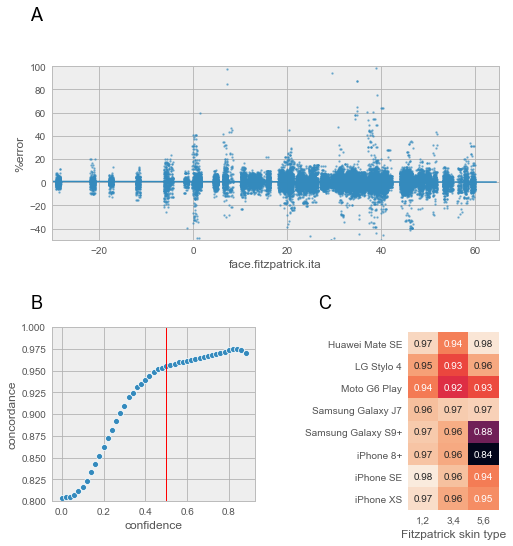

In [13]:
confidence_cuttoff=0.5
data = (calibration_df.
        query('method=="acf"').
        dropna(subset=['noninHR']).
        assign(hr = lambda x: np.where(x['redConf']>confidence_cuttoff, x['redHR'], 
                                       np.where(x['greenConf']>confidence_cuttoff, x['greenHR'], np.nan))).
        dropna(subset=['hr']).
        assign(fitzpatrick_group = lambda x: pd.cut(x['face.fitzpatrick'], 
                                                    [1,2,4,6], labels=['1,2', '3,4', '5,6'])))

plt.figure(figsize=(8, 8))
##Figure 2a % error vs skin color wihtout filtering
#TODO verify %error
#TODO add separators for ita cutoffs
#TODO clean up 
#Redo based on interpolation and single measure per person
#TODO color by celeb skintone
ax = plt.subplot(2,1,1);
sns.regplot(x='face.fitzpatrick.ita', y='%error',
           scatter_kws={"s": 2, 'alpha':.5},
           data=data, 
           x_jitter=.5, ax=ax);

plt.ylim(-50,100);
plt.xlim(-30,65);
#plt.subplot(2,3,3)
#sns.distplot(data['%error'].dropna(), vertical=True)

##Figure 2b %confidence vs missing data
ax = plt.subplot(2,2,3)
sns.scatterplot(x='confidence', y='concordance', data=confidenceDistributions)
plt.ylim([.8,1])
plt.plot([.5,.5], [.8,1], 'r')

##Figure 2c - heatmap
# TODO - redo single measure per person and interpolation
ax = plt.axes([0.743116, 0.110000, 0.156884, 0.308000])
c = data.groupby(['phone', 'fitzpatrick_group']).apply(lambda d: ccc(d['hr'],d['noninHR'])).unstack('fitzpatrick_group', 'phone')
sns.heatmap(c, annot=True,cbar=False) #cbar_kws={'min':0, 'max':1});
plt.ylabel('')

plt.figure(1).text(0.087358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.087358, 0.459621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.587358, 0.459621, 'C', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");

plt.xlabel('Fitzpatrick skin type');

plt.savefig('manuscript/figure2.pdf');



### Supplemental Figure for HR validation

In [18]:
df_hr.head()

,recordId,healthCode,externalId,dataGroups,appVersion,createdOn,createdOnTimeZone,phoneInfo,metadata.startDate,metadata.endDate,...,window,startTime,stopTime,tag,fitbit.timestamp,fitbit.hr,polar.timestamp,polar.hr,activity,os
1,001e11b5-54ac-4f46-a09f-b5039ea2415e,11595678-ad73-455b-8889-fa305ccad597,PMI133,clinic2,"version 1.6.1, build 40",2018-07-11 05:31:04,-700,Samsung SM-G930V,1.531287e+09,1.531287e+09,...,Window1,2018-07-11 05:30:06,2018-07-11 05:30:16,motion,2018-07-11 05:30:11,93.0,NaN,NaN,tecumesh,Android
2,001e11b5-54ac-4f46-a09f-b5039ea2415e,11595678-ad73-455b-8889-fa305ccad597,PMI133,clinic2,"version 1.6.1, build 40",2018-07-11 05:31:04,-700,Samsung SM-G930V,1.531287e+09,1.531287e+09,...,Window2,2018-07-11 05:30:07,2018-07-11 05:30:17,motion,2018-07-11 05:30:13,93.5,NaN,NaN,tecumesh,Android
3,001e11b5-54ac-4f46-a09f-b5039ea2415e,11595678-ad73-455b-8889-fa305ccad597,PMI133,clinic2,"version 1.6.1, build 40",2018-07-11 05:31:04,-700,Samsung SM-G930V,1.531287e+09,1.531287e+09,...,Window3,2018-07-11 05:30:08,2018-07-11 05:30:18,motion,2018-07-11 05:30:13,93.5,NaN,NaN,tecumesh,Android
4,001e11b5-54ac-4f46-a09f-b5039ea2415e,11595678-ad73-455b-8889-fa305ccad597,PMI133,clinic2,"version 1.6.1, build 40",2018-07-11 05:31:04,-700,Samsung SM-G930V,1.531287e+09,1.531287e+09,...,Window4,2018-07-11 05:30:09,2018-07-11 05:30:19,motion,2018-07-11 05:30:13,93.5,NaN,NaN,tecumesh,Android
5,001e11b5-54ac-4f46-a09f-b5039ea2415e,11595678-ad73-455b-8889-fa305ccad597,PMI133,clinic2,"version 1.6.1, build 40",2018-07-11 05:31:04,-700,Samsung SM-G930V,1.531287e+09,1.531287e+09,...,Window5,2018-07-11 05:30:10,2018-07-11 05:30:20,motion,2018-07-11 05:30:13,93.5,NaN,NaN,tecumesh,Android


In [19]:
#from pandas_profiling import ProfileReport
#profile = ProfileReport(df_hr, title='HR summary')
#profile.to_notebook_iframe()

df_hr.columns
df_hr.shape
df_hr.dropna(subset=['polar.hr']).
      originalTable)
#data = (calibration_df.
#        query('method=="acf"').
#        dropna(subset=['noninHR']).
#        assign(hr = lambda x: np.where(x['redConf']>confidence_cuttoff, x['redHR'], 
#                                       np.where(x['greenConf']>confidence_cuttoff, x['greenHR'], np.nan))).
#        dropna(subset=['hr']).
#        assign(fitzpatrick_group = lambda x: pd.cut(x['face.fitzpatrick'], 
#                                                    [1,2,4,6], labels=['1,2', '3,4', '5,6'])))


SyntaxError: invalid syntax (<ipython-input-19-5fe81fe7a82e>, line 7)